# 파트 09
----
이번 파트에서는 선형회귀분석을 행한다. 전체 선형회귀분석 외에도 이전 파트에서 시계열 클러스터링을 이용하여 구분한 행정구역들을 별개로 회귀분석을 시행하였다.

In [875]:
%matplotlib inline
from __future__ import division
from __future__ import print_function
import sklearn.preprocessing
import sklearn.feature_selection

In [876]:
# setting the folder path and read in data
path = 'raw_data\\'
df_original = pd.read_csv(path + 'estate_ts_y.csv', encoding='utf-8')

In [877]:
# changing the column order
df_columns = [u'year', u'area_code', u'label', u'trade_vol',
              u'mov_vol', u'head_ratio', u'head_male_ratio', u'head_age', u'multi_ratio', u'ppl_per_house',
              u'mov_ppl_vol', u'mov_male_ratio', u'pop_change_ratio', u'built',
              u'r_1', u'r_2', u'r_3', u'r_5', u'r_4', u'r_6', u'r_9',
              u'ppa_median', u'ppa_mean', u'ppa_median_log']

df = df_original[df_columns]

In [878]:
df.head()

,year,area_code,label,trade_vol,mov_vol,head_ratio,head_male_ratio,head_age,multi_ratio,ppl_per_house,...,r_1,r_2,r_3,r_5,r_4,r_6,r_9,ppa_median,ppa_mean,ppa_median_log
0,2006,11170,0.0,2415.0,83396.0,0.791513,0.630687,40.849627,0.349069,1.704194,...,0.049918,-0.013934,0.003537,-0.000096,-0.000288,-0.001487,-0.019018,564.971751,602.588603,6.336776
1,2006,11200,0.0,4204.0,102922.0,0.768776,0.671212,39.905427,0.374400,1.777152,...,-0.001506,0.000418,-0.001059,0.000933,0.002857,-0.000641,-0.010270,466.329966,478.887059,6.144893
2,2006,11215,0.0,2658.0,125386.0,0.794283,0.649972,38.791690,0.380864,1.801972,...,-0.043442,0.011524,0.035881,0.001459,0.005559,-0.000949,-0.007082,501.504514,512.469919,6.217613
3,2006,11230,0.0,3690.0,118019.0,0.781713,0.658541,40.292758,0.351901,1.726120,...,0.003838,-0.012532,0.000373,-0.000441,0.003991,-0.001246,-0.006550,319.865320,325.644840,5.767900
4,2006,11260,0.0,3832.0,123849.0,0.783712,0.661938,41.021491,0.413431,1.872409,...,-0.036326,-0.000275,0.013250,0.000275,-0.000024,-0.000727,0.013080,267.732774,275.041733,5.589989


In [879]:
# reshaping the dataframe for easier use
df.label = df.loc[:, 'label'].astype(int)
df = df.set_index(['label', 'area_code'])

In [880]:
# just a helper list
ppa_columns = ['ppa_mean', 'ppa_median', 'ppa_median_log']

In [881]:
# custom class that contains three dataframes according to respective labels
class Cases_df:
    def __init__(self, df):
        self.all = Custom_df(df)
        self.one = Custom_df(df.loc[0])
        self.two = Custom_df(df.loc[1])

In [882]:
# custom class containing a fitted linear regression model,
# parameters, targets, and area codes for easy access
class Custom_df:
    def __init__(self, df):
        # create a scaler for a given dataframe
        self.df_scaler = Scaler(df)
        
        # create a normalized copy
        self.df_normal = pd.DataFrame(self.df_scaler.X.transform(df), index=df.index, columns=df.columns)
        
        # patching things up
        if 0 in self.df_normal.index:
            self.df_normal = self.df_normal.reset_index(0)
        
        self.dfX, self.dfy, self.result = optimize_fit(self.df_normal)
        
        self.area_codes = df.index.unique()

In [883]:
# custom scaler object for easier use
class Scaler:
    def __init__(self, df):
        self.X = sk.preprocessing.StandardScaler()
        self.ppa_mean = sk.preprocessing.StandardScaler()
        self.ppa_median = sk.preprocessing.StandardScaler()
        self.ppa_median_log = sk.preprocessing.StandardScaler()
        
        self.X.fit(df)
        self.ppa_mean.fit(df[['ppa_mean']])
        self.ppa_median.fit(df[['ppa_median']])
        self.ppa_median_log.fit(df[['ppa_median_log']])

In [884]:
# this is an automated linear regression method
# first throws out variables with high F probability (greater than 0.01)
# then throws out variables that aren't statistically significant
def optimize_fit(df_normal):
    dfX = sm.add_constant(df_normal.drop(ppa_columns, axis=1))
    dfy = pd.DataFrame(df_normal, columns=ppa_columns)
    
    F, F_p = sk.feature_selection.f_regression(dfX, dfy.ppa_median_log)
    f_reg = pd.DataFrame(F_p, index=dfX.columns, columns=['F_p'])
    
    dfX = dfX.drop(f_reg.loc[f_reg.F_p > 0.01].index, axis=1)
    
    # fit model
    model = sm.OLS(dfy.ppa_median_log, dfX)
    result = model.fit()
    
    conf_int = result.conf_int()
    
    dfX = dfX.drop(conf_int[conf_int.product(axis=1) < 0].index, axis=1)
    
    model = sm.OLS(dfy.ppa_median_log, dfX)
    result = model.fit()
    
    return dfX, dfy, result

In [885]:
# custom plotting function
def plot_results(df_custom):
    # plot predicted price vs actual price
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    sns.regplot(df_custom.result.predict(df_custom.dfX), df_custom.df_normal.ppa_median_log)
    plt.xlabel('Predicted scaled log(median price)')
    plt.ylabel('Actual scaled log(median price)')

    plt.subplot(1, 2, 2)
    sns.regplot(np.exp(df_custom.df_scaler.ppa_median_log.inverse_transform(df_custom.result.predict(df_custom.dfX))),
                np.exp(df_custom.df_scaler.ppa_median_log.inverse_transform(df_custom.df_normal.ppa_median_log)))
    plt.xlabel('Predicted median price')
    plt.ylabel('Actual median price')
        
    # plot price different distributions
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    sns.distplot(df_custom.result.predict(df_custom.dfX) - df_custom.df_normal.ppa_median_log)
    plt.xlabel('Log median price difference distribution')

    plt.subplot(1, 2, 2)
    sns.distplot(np.exp(df_custom.df_scaler.ppa_median_log.inverse_transform(df_custom.result.predict(df_custom.dfX))) -
                 np.exp(df_custom.df_scaler.ppa_median_log.inverse_transform(df_custom.df_normal.ppa_median_log)))
    plt.xlabel('Median price difference distribution')

In [886]:
# create a custom object
df_cases = Cases_df(df)

                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     602.8
Date:                Thu, 06 Jul 2017   Prob (F-statistic):               0.00
Time:                        20:06:44   Log-Likelihood:                -846.03
No. Observations:                1490   AIC:                             1716.
Df Residuals:                    1478   BIC:                             1780.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               0.3946      0.024     

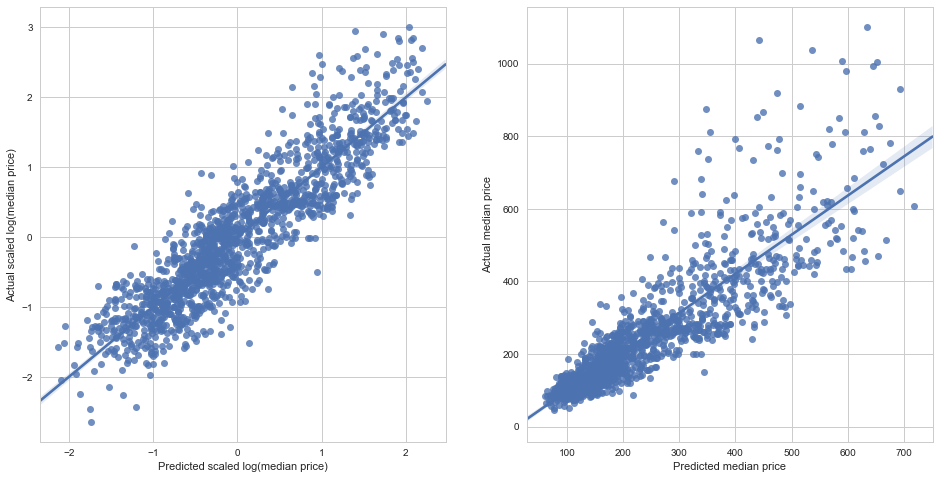

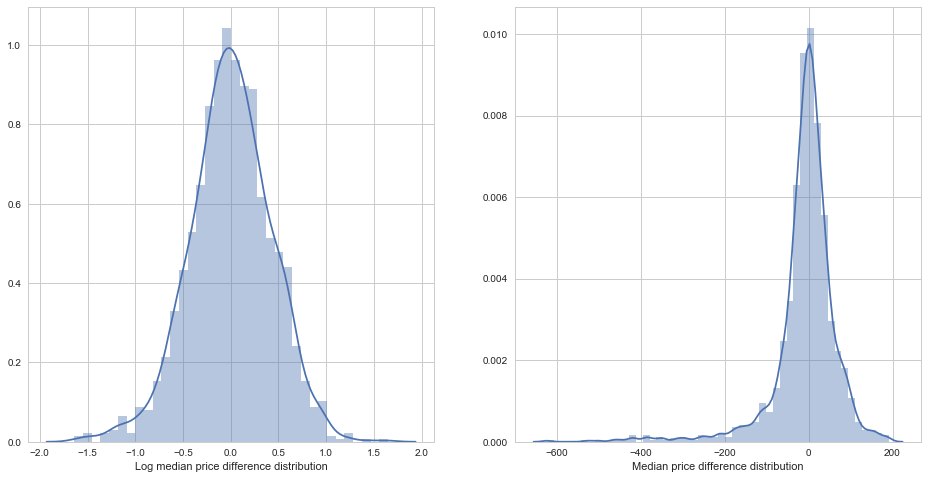

In [887]:
# print the fitted result for all area codes
print(df_cases.all.result.summary())
plot_results(df_cases.all)

                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     107.9
Date:                Thu, 06 Jul 2017   Prob (F-statistic):          5.05e-122
Time:                        20:06:45   Log-Likelihood:                -389.90
No. Observations:                 490   AIC:                             801.8
Df Residuals:                     479   BIC:                             847.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
year                0.3203      0.042     

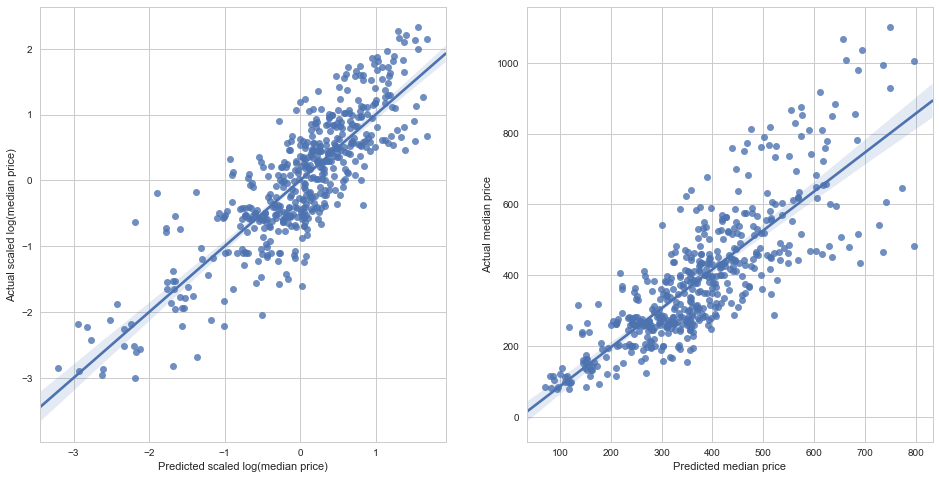

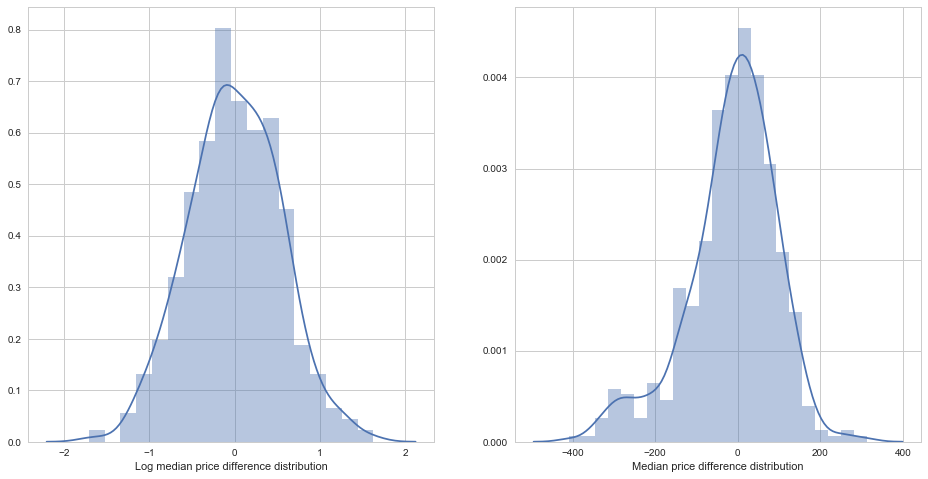

In [888]:
# print the fitted result for all area codes with label 0
print(df_cases.one.result.summary())
plot_results(df_cases.one)

                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     298.0
Date:                Thu, 06 Jul 2017   Prob (F-statistic):          1.01e-274
Time:                        20:06:46   Log-Likelihood:                -763.96
No. Observations:                1000   AIC:                             1546.
Df Residuals:                     991   BIC:                             1590.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
year                 0.5299      0.023  

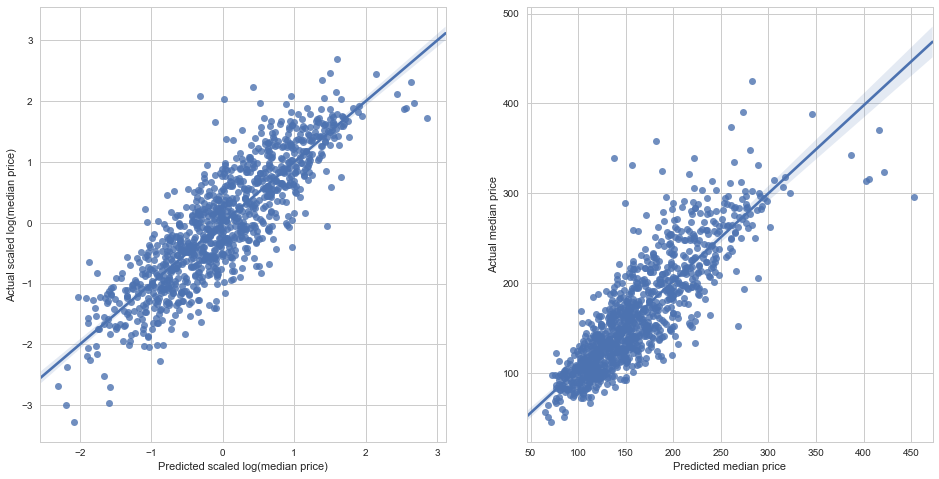

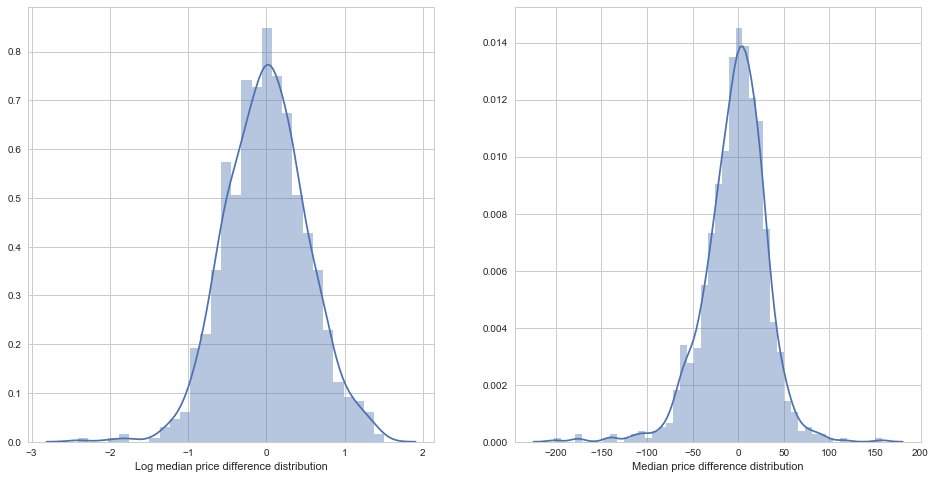

In [889]:
# print the fitted result for all area codes with label 1
print(df_cases.two.result.summary())
plot_results(df_cases.two)